<a href="https://colab.research.google.com/github/DiegoCorona/TensorFlow2-for-Deep-Learning/blob/main/Week3_Tensorflow2_for_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [87]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [88]:
# Save the input and target variables

# print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [89]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis= 0))/ targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [90]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, targets, test_size = 0.1)
print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [91]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
                      Dense(128, activation = 'relu', input_shape = (train_data.shape[1], )),
                      Dense(128, activation = 'relu'), 
                      Dense(128, activation = 'relu'),
                      Dense(128, activation = 'relu'),
                      Dense(128, activation = 'relu'),
                      Dense(128, activation = 'relu'),
                      Dense(1)
  ])
  return model

model = get_model()

In [92]:
# Print the model summary

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_85 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_86 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_87 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_88 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_89 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_90 (Dense)             (None, 1)               

In [93]:
# Compile the model

model.compile(optimizer= 'adam', loss = 'mse', metrics = ['mae'])

In [94]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_target, epochs= 100,
                    validation_split = 0.15, batch_size = 64, verbose = False)

In [95]:
# Evaluate the model on the test set
model.evaluate(test_data, test_target, verbose = 2)


2/2 - 0s - loss: 0.6697 - mae: 0.5753


[0.6696616411209106, 0.5753400325775146]

#### Plot the learning curves

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

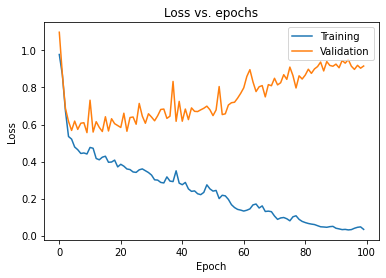

In [97]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [98]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [99]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate), 
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [100]:
# Re-build the model with weight decay and dropout layers

model_reg = get_regularised_model(1e-5, 0.3)

In [101]:
# Compile the model
model_reg.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae'])


In [102]:
# Train the model, with some of the data reserved for validation

history = model_reg.fit(train_data, train_target, epochs= 100, validation_split= 0.15, verbose = 0)

In [103]:
# Evaluate the model on the test set

model_reg.evaluate(test_data, test_target, verbose= 2)

2/2 - 0s - loss: 0.5584 - mae: 0.5478


[0.5584243535995483, 0.5478193163871765]

#### Plot the learning curves

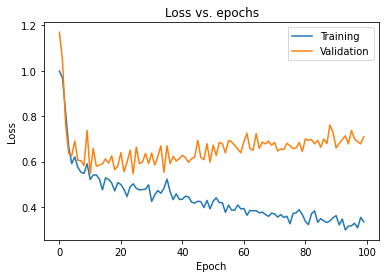

In [104]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [105]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallBack(Callback):
  def on_train_begin(self, logs = None):
    print('Starting training...')

  def on_epoch_begin(self, epoch, logs = None):
    print(f'Starting epoch {epoch}')

  def on_train_batch_begin(self, batch, logs = None):
    print(f'Training: Starting batch {batch}')

  def on_train_batch_end(self, batch, logs = None):
    print(f'Training: Finished batch {batch}')
  
  def on_epoch_end(self, epoch, logs = None):
    print(f'Finished epoch {epoch}')

  def on_train_end(self, logs = None):
    print('Finished training')


class TestingCallBack(Callback):
  def on_test_begin(self, logs = None):
    print('Starting testing...')

  def on_test_batch_begin(self, batch, logs = None):
    print(f'Testing: Starting batch {batch}')

  def on_test_batch_end(self, batch, logs = None):
    print(f'Testing: Finished batch {batch}')

  def on_test_end(self, logs = None):
    print('Finished testing')


class PredictionCallBack(Callback):
  def on_predict_begin(self, logs = None):
    print('Starting prediction...')

  def on_predict_batch_begin(self, batch, logs = None):
    print(f'Prediction: Starting batch {batch}')

  def on_predict_batch_end(self, batch, logs = None):
    print(f'Prediction: Finished batch {batch}')

  def on_predict_end(self, logs = None):
    print('Finished prediction.')


In [106]:
# Re-build the model

model_callback = get_regularised_model(1e-5, 0.3)

In [107]:
# Compile the model

model_callback.compile(optimizer = 'adam', loss = 'mse')

#### Train the model with the callback

In [108]:
# Train the model, with some of the data reserved for validation

model_callback.fit(train_data, train_target, epochs= 3, batch_size= 128, verbose = False, callbacks= [TrainingCallBack()])

Starting training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training


In [109]:
# Evaluate the model

model_callback.evaluate(test_data, test_target, callbacks= [TestingCallBack()], verbose = False)

Starting testing...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing


0.7530694603919983

In [110]:
# Make predictions with the model

model_callback.predict(test_data, verbose = False, callbacks= [PredictionCallBack()])

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction.


array([[ 0.01169017],
       [ 0.05544508],
       [ 0.0066346 ],
       [ 0.0333013 ],
       [ 0.01984318],
       [-0.03586662],
       [-0.0636958 ],
       [-0.04922462],
       [-0.01961978],
       [ 0.02654575],
       [-0.05045548],
       [ 0.0207279 ],
       [ 0.03011334],
       [ 0.01951613],
       [-0.04563798],
       [-0.01019764],
       [ 0.02142051],
       [ 0.01825288],
       [ 0.04380556],
       [ 0.02244684],
       [ 0.02941429],
       [ 0.02931935],
       [-0.05743355],
       [ 0.03650547],
       [-0.0322676 ],
       [ 0.03179359],
       [ 0.01051837],
       [-0.05288906],
       [ 0.0512009 ],
       [ 0.01371125],
       [-0.01685657],
       [ 0.02911518],
       [-0.02828344],
       [-0.02869967],
       [ 0.02060968],
       [-0.05454212],
       [-0.04439827],
       [-0.01944059],
       [ 0.03205758],
       [-0.02776426],
       [ 0.01434237],
       [-0.02327708],
       [ 0.02692392],
       [-0.04691778],
       [-0.04741731]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [121]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer= 'adam', loss = 'mae')
unreg_history = unregularised_model.fit(train_data, train_target, epochs= 100, 
                                        validation_split= 0.15, batch_size = 64, verbose = False,
                                        callbacks = [tf.keras.callbacks.EarlyStopping(patience= 2)])

In [122]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_target, verbose = 2)

2/2 - 0s - loss: 0.4838


0.48376592993736267

In [123]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss = 'mse')
reg_history = regularised_model.fit(train_data, train_target, epochs= 100,
                                    validation_split = 0.15, batch_size = 64, verbose = False,
                                    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

In [124]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_target, verbose = 2)

2/2 - 0s - loss: 0.4219


0.4218854606151581

#### Plot the learning curves

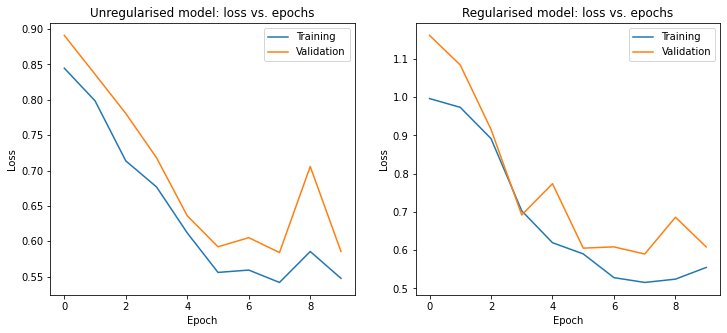

In [125]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()